# 50K simulations results

Let's test the 50K simulations results:

In [1]:
from pathlib import Path
from collections import defaultdict

import tskit
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from tskitetude import get_project_dir

Let's declare some stuff

In [2]:
repeats = 5
breed_size = [1, 2, 5, 10, 15, 20]
simulation = "50K_simulations"
reference_prefix = "results-reference"
compara_prefix = "results-compara"
chromosome = "26"

In [3]:
def collect_stats(results_prefix, simulation, chromosome, breed_size, repeats):

    data = defaultdict(list)
    prefix = get_project_dir() / results_prefix / simulation

    for i in breed_size:

        for j in range(repeats):
            run = f"{i}_breeds-{j}-50K"
            filename = prefix / run / "tsinfer" / f"SMARTER-OA-OAR3-forward-0.4.10-50K.focal.{chromosome}.trees"

            if not  filename.exists():
                print(f"File {filename} does not exist")
                continue

            ts = tskit.load(filename)

            # track some stats for tree object
            data["breeds"] += [i]
            data["repeat"] += [j]
            data["filename"] += [filename]
            data["sites"] += [ts.num_sites]
            data["trees"] += [ts.num_trees]
            data["edges"] += [ts.num_edges]
            data["individuals"] += [ts.num_individuals]
            data["samples"] += [ts.num_samples]
            data["mutations"] += [ts.num_mutations]
            data["nodes"] += [ts.num_nodes]
            data["populations"] += [ts.num_populations]

    return pd.DataFrame(data)

Read data from reference simulations:

In [4]:
reference = collect_stats(reference_prefix, simulation, chromosome, breed_size, repeats)
reference.head()

,breeds,repeat,filename,sites,trees,edges,individuals,samples,mutations,nodes,populations
0,1,0,/home/core/TSKITetude/results-reference/50K_si...,792,752,7717,24,48,792,1355,1
1,1,1,/home/core/TSKITetude/results-reference/50K_si...,773,732,7525,24,48,773,1309,1
2,1,2,/home/core/TSKITetude/results-reference/50K_si...,673,616,5974,23,46,673,1102,1
3,1,3,/home/core/TSKITetude/results-reference/50K_si...,766,697,6184,24,48,766,1168,1
4,1,4,/home/core/TSKITetude/results-reference/50K_si...,573,438,3153,21,42,573,707,1


Collect stats for compara:

In [5]:
compara = collect_stats(compara_prefix, simulation, chromosome, breed_size, repeats)
compara.head()

,breeds,repeat,filename,sites,trees,edges,individuals,samples,mutations,nodes,populations
0,1,0,/home/core/TSKITetude/results-compara/50K_simu...,791,557,5667,24,48,1865,1006,1
1,1,1,/home/core/TSKITetude/results-compara/50K_simu...,774,542,5664,24,48,1751,979,1
2,1,2,/home/core/TSKITetude/results-compara/50K_simu...,675,476,4577,23,46,1476,846,1
3,1,3,/home/core/TSKITetude/results-compara/50K_simu...,761,528,4822,24,48,1412,918,1
4,1,4,/home/core/TSKITetude/results-compara/50K_simu...,555,333,2443,21,42,786,553,1


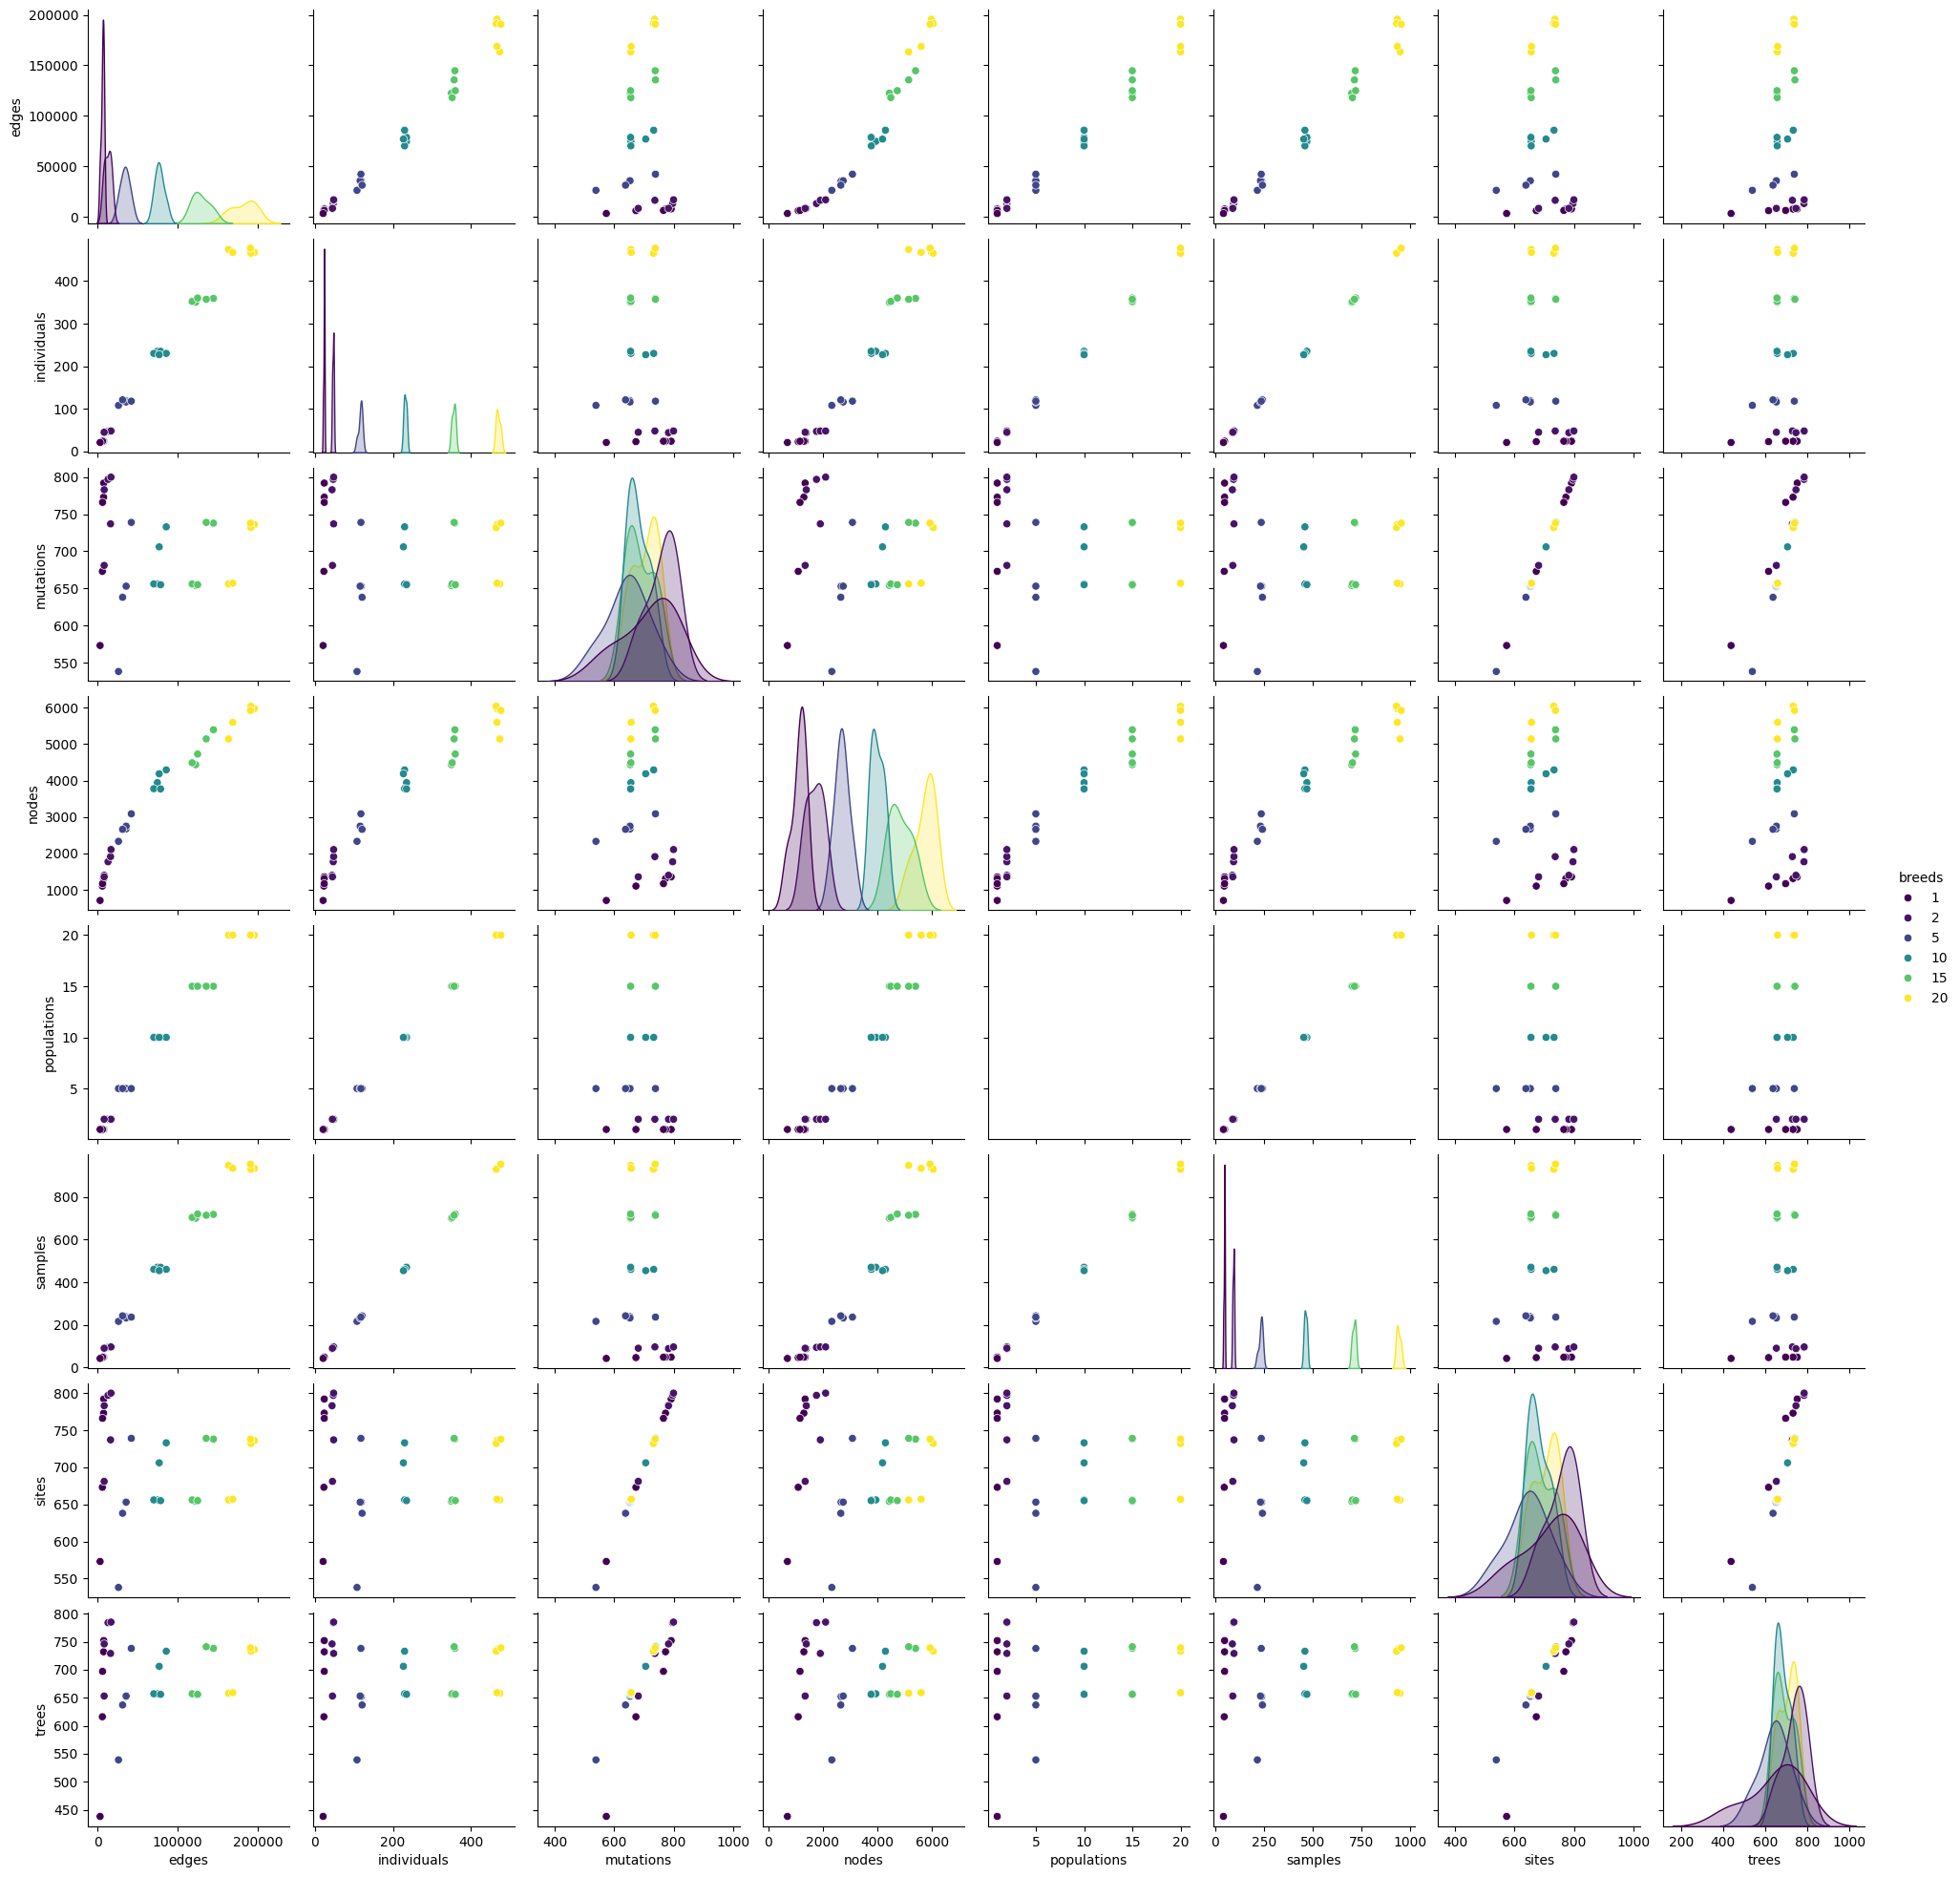

In [6]:
sns.pairplot(reference[reference.columns.difference(['repeat'])], hue="breeds", palette="viridis")

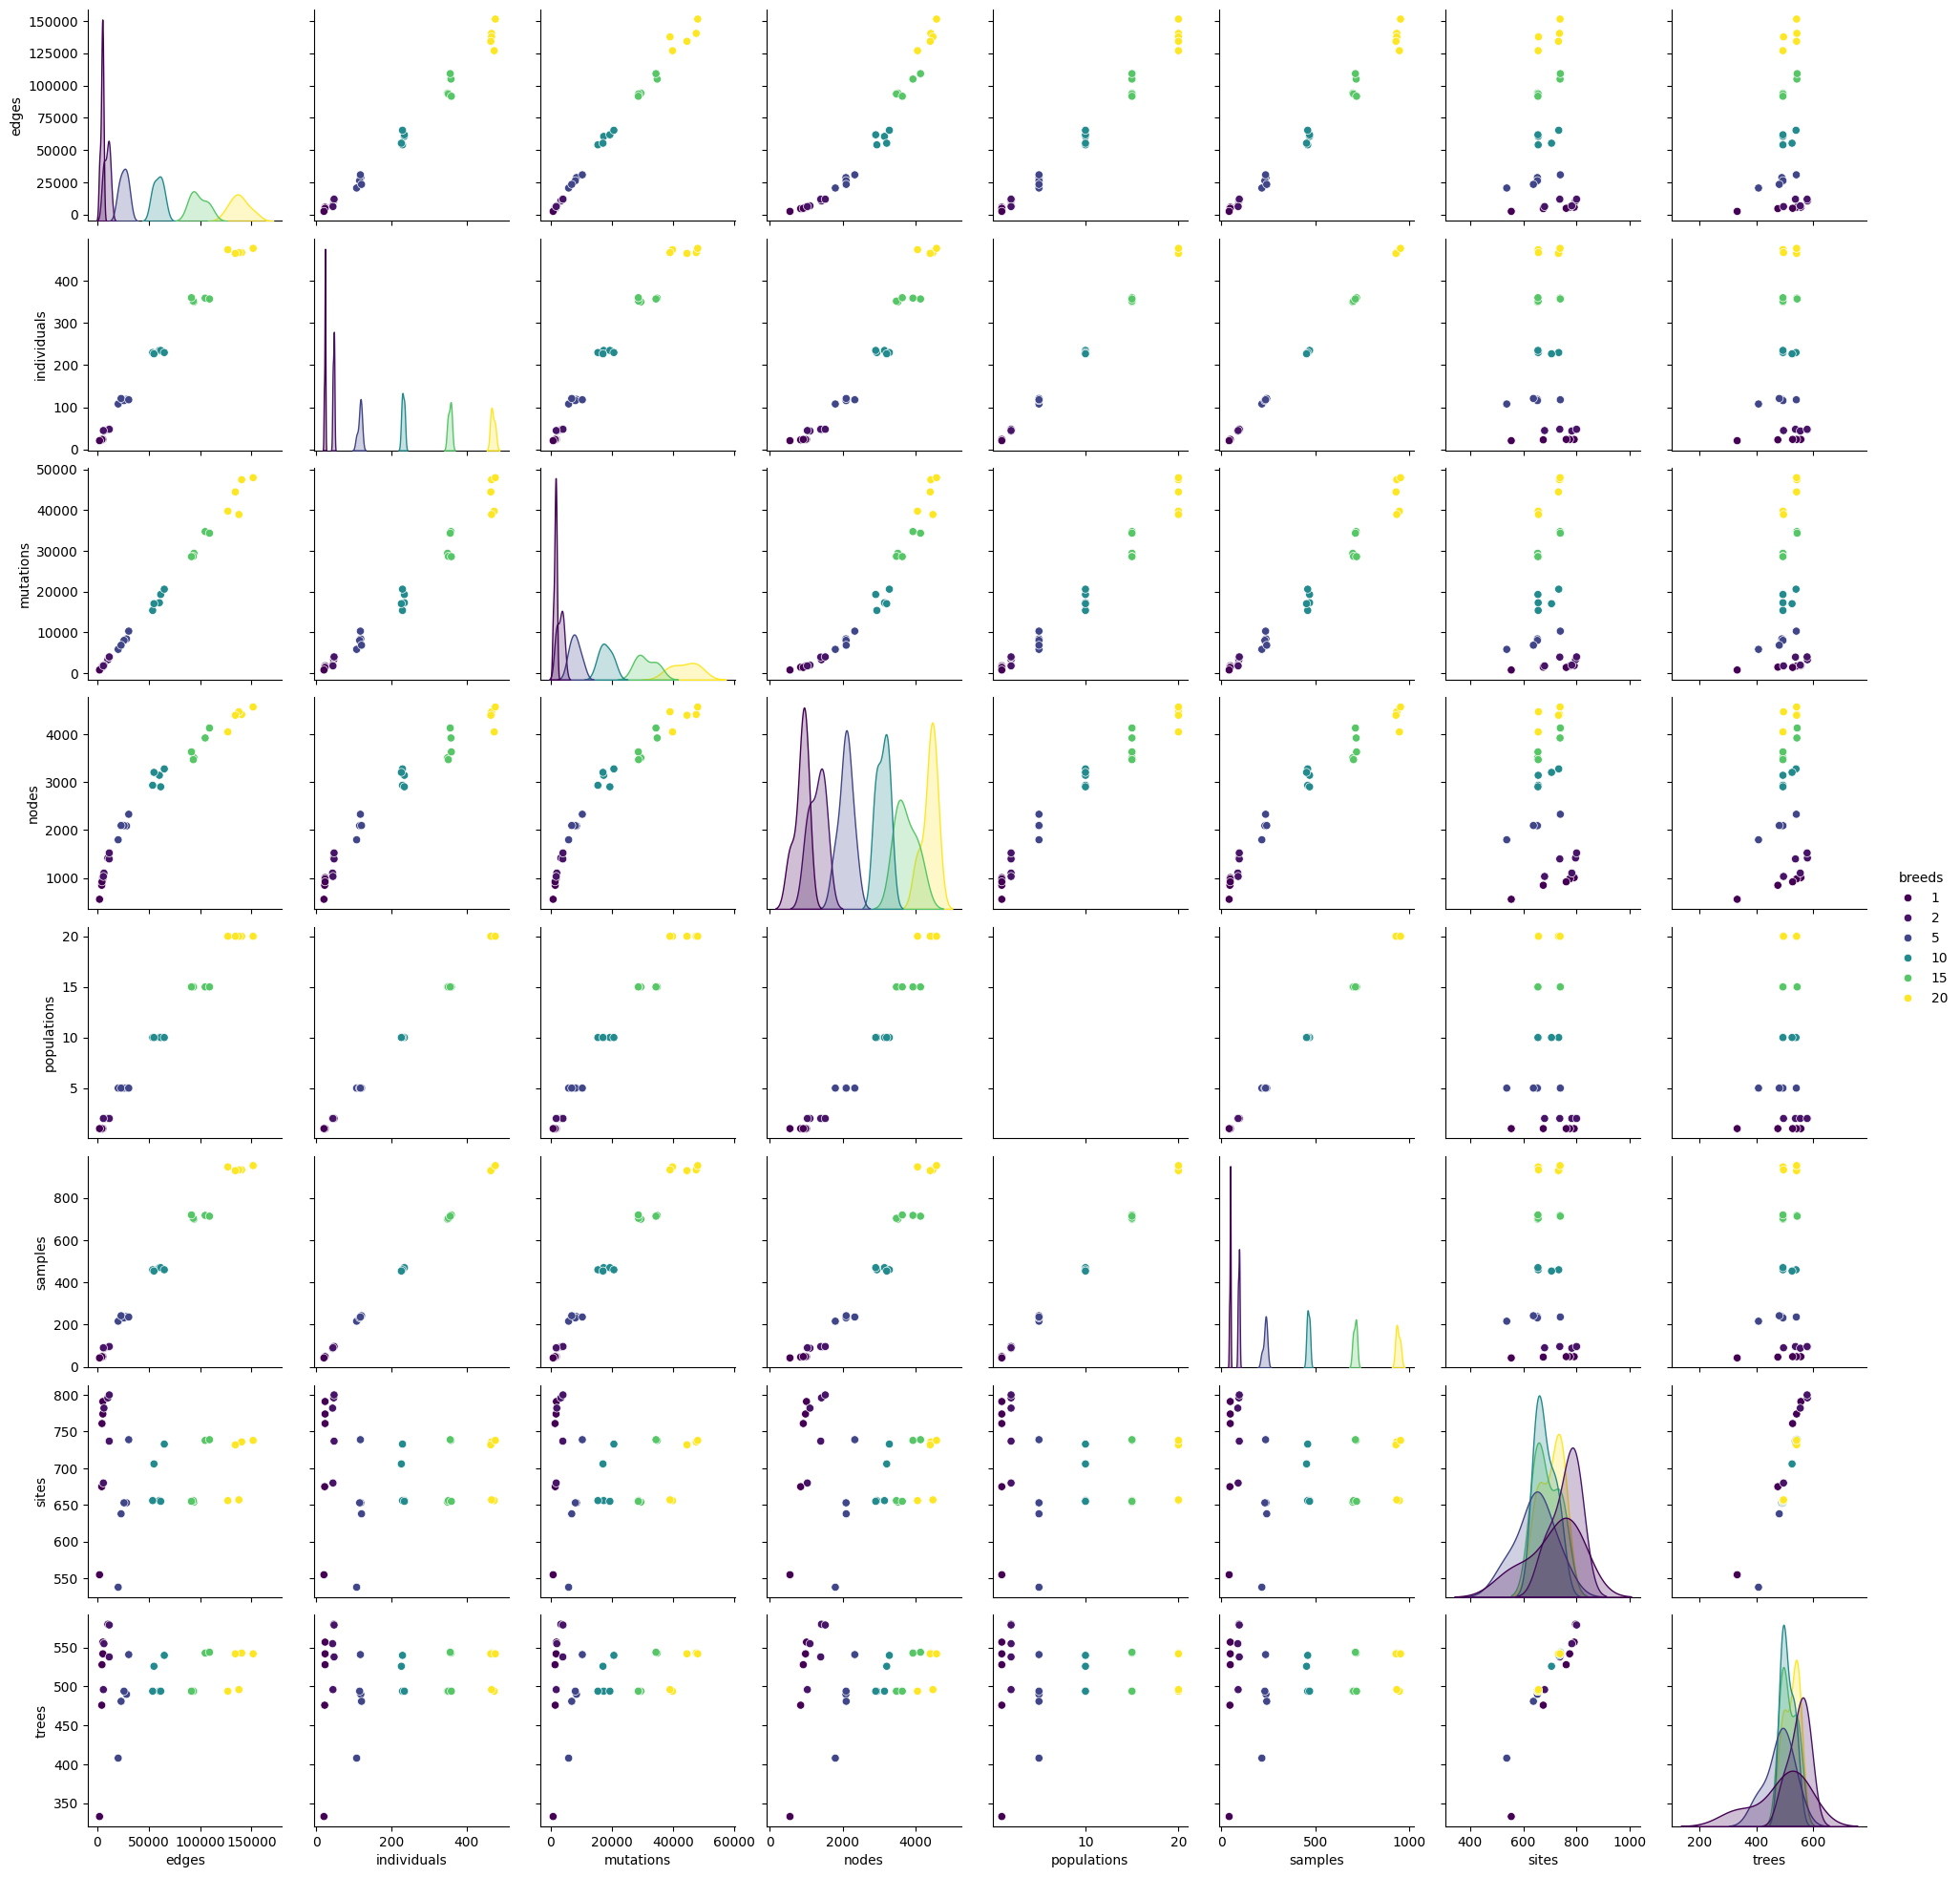

In [7]:
sns.pairplot(compara[compara.columns.difference(["repeat"])], hue="breeds", palette="viridis")

It seems that the number of mutation is higher using the *compara* approach instead of the *reference* approach. Let's
try to model the number of mutations relying on the numer or samples. Try to fit a linear model using `sns.regplot`:

<Axes: xlabel='samples', ylabel='mutations'>

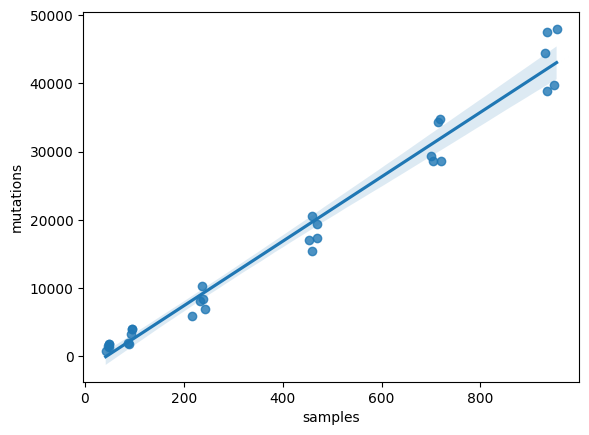

In [8]:
sns.regplot(data=compara, x="samples", y="mutations", ci=95)

Try to fit a 2nd degree polynomial model using `np.polyfit`:

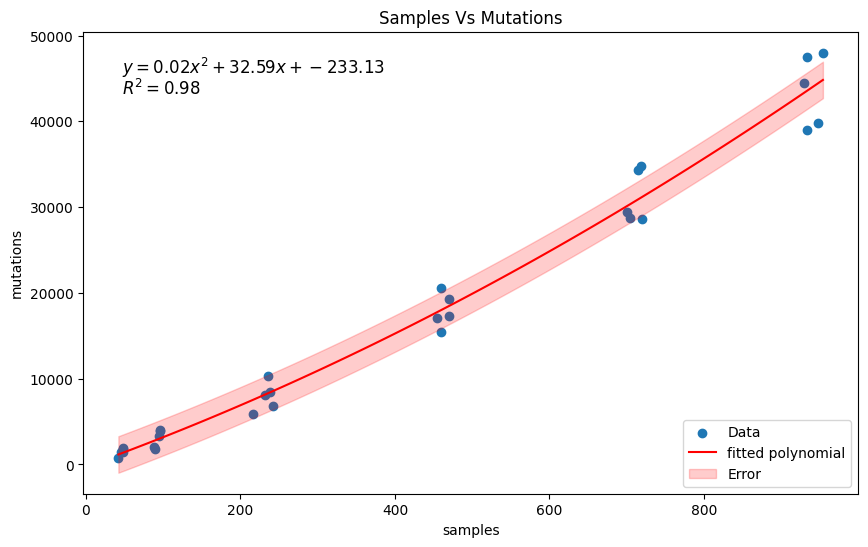

In [9]:
# fit a polynomial to the data
coeffs = np.polyfit(compara['samples'], compara['mutations'], 2)
poly = np.poly1d(coeffs)

# generate values for x and y
x_vals = np.linspace(compara['samples'].min(), compara['samples'].max(), 100)
y_vals = poly(x_vals)

# calculate residuals
y_fit = poly(compara['samples'])
residuals = compara['mutations'] - y_fit
std_residuals = np.std(residuals)

# calculate R^2
ss_res = np.sum(residuals**2)
ss_tot = np.sum((compara['mutations'] - np.mean(compara['mutations']))**2)
r2 = 1 - (ss_res / ss_tot)

# plot the data
plt.figure(figsize=(10, 6))
plt.scatter(compara['samples'], compara['mutations'], label='Data')
plt.plot(x_vals, y_vals, color='red', label='fitted polynomial')
plt.fill_between(x_vals, y_vals - std_residuals, y_vals + std_residuals, color='red', alpha=0.2, label='Error')

# add formula to the plot
formula = f'$y = {coeffs[0]:.2f}x^2 + {coeffs[1]:.2f}x + {coeffs[2]:.2f}$'
r2_text = f'$R^2 = {r2:.2f}$'
plt.text(0.05, 0.95, formula, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')
plt.text(0.05, 0.90, r2_text, transform=plt.gca().transAxes, fontsize=12, verticalalignment='top')

# Add labels and title
plt.xlabel('samples')
plt.ylabel('mutations')
plt.title('Samples Vs Mutations')
plt.legend(loc='lower right')

# Show the plot
plt.show()